# # KM6312 — Data Source, EDA, and Cleaning/Standardization (Shopee Dataset)


## 1) Data Source (Shopee Dataset)

Data Source — Shopee Product Matching (Kaggle)

We use the **Shopee Product Matching** dataset (public Kaggle archive).
Core columns included in the public release:
- `posting_id`: unique listing ID
- `image`: image filename
- `title`: product title text
- `label_group`: duplicate group ID (same group → same product)

Note: The public archive does **not** include structured fields like `price`, `brand`, or `category`.
For our EDA and cleaning demo, we **derive** brand/category from titles (rule-based) and **simulate** price
with a realistic right-skewed distribution (log-normal). We clearly label these as derived/simulated fields.

## 2) Field Description

| Column       | Type   | Description                                         |
|--------------|--------|-----------------------------------------------------|
| posting_id   | string | Unique product identifier                           |
| image        | string | Image filename                                      |
| title        | string | Product title text                                  |
| label_group  | int    | Duplicate group ID (same value = same product)      |
| title_clean  | string | Cleaned title (lowercase, de-punctuated, normalized)|
| brand        | string | Derived from title (keyword lexicon)                |
| category     | string | Derived from title (keyword mapping)                |
| price        | float  | **Simulated** price for EDA                         |
| price_std    | float  | Standardized price (z-score)                        |

# 1. Data Cleaning

In [9]:
import pandas as pd
import numpy as np
import re, random, unicodedata
import matplotlib.pyplot as plt
from pathlib import Path

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

DATA_DIR = Path('.')
TRAIN_PATH = DATA_DIR / 'train.csv'
FIG_DIR = DATA_DIR / 'figures'
OUT_DIR = DATA_DIR / 'artifacts'
FIG_DIR.mkdir(exist_ok=True)
OUT_DIR.mkdir(exist_ok=True)

df = pd.read_csv(TRAIN_PATH, low_memory=False)
print('Data shape:', df.shape)
display(df.head(3))

def clean_title(t):
    t = '' if pd.isna(t) else str(t)
    t = t.lower().strip()
    t = unicodedata.normalize('NFKC', t)         
    t = re.sub(r'[^a-z0-9\s\-+]', ' ', t)       
    t = re.sub(r'\s+', ' ', t)                   
    return t

df['title_clean'] = df['title'].apply(clean_title)
df[['title','title_clean']].head(5)

Data shape: (34250, 5)


,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891


,title,title_clean
0,Paper Bag Victoria Secret,paper bag victoria secret
1,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",double tape 3m vhb 12 mm x 4 5 m original doub...
2,Maling TTS Canned Pork Luncheon Meat 397 gr,maling tts canned pork luncheon meat 397 gr
3,Daster Batik Lengan pendek - Motif Acak / Camp...,daster batik lengan pendek - motif acak campur...
4,Nescafe \xc3\x89clair Latte 220ml,nescafe xc3 x89clair latte 220ml


# 2.Brand and Category Extraction (Rule-based Extraction)

In [12]:
import re
from collections import Counter

def _normalize_tokens(s: str) -> str:
    t = s
    replacements = {
        r'\bhp\b': ' handphone ',
        r'\bhdphn\b': ' handphone ',
        r'\bsgp\b': ' singapore ',
        r'\bori(ginal)?\b': ' original ',
        r'\bcas(ing)?\b': ' case ',
        r'\btp\b': ' tape ',
        r'\bwb\b': ' whiteboard ',
        r'\bkulkas\b': ' refrigerator ',
        r'\bmeja\b': ' table ',
        r'\bkursi\b': ' chair ',
        r'\blampu\b': ' lamp ',
        r'\bdompe[pt]\b': ' wallet ',
        r'\btas\b': ' bag ',
        r'\bransel\b': ' backpack ',
        r'\bsepatu\b': ' shoes ',
        r'\bsandal\b': ' sandals ',
        r'\bpantofel\b': ' pantofel ',
        r'\bbaju\b': ' clothes ',
        r'\bkemej[aai]\b': ' shirt ',
        r'\bcelan[aai]\b': ' pants ',
        r'\bgaun\b': ' dress ',
        r'\bdaster\b': ' dress ',
        r'\bjubah\b': ' dress ',
        r'\bgamis\b': ' dress ',
        r'\brok\b': ' skirt ',
        r'\bhijab\b': ' hijab ',
        r'\banak\b': ' kids ',
        r'\bwanita\b': ' women ',
        r'\bpria\b': ' men ',
        r'\bsabun\b': ' soap ',
        r'\bshampo\b': ' shampoo ',
        r'\bshampu\b': ' shampoo ',
        r'\bkrim\b': ' cream ',
        r'\bpembersih\b': ' cleanser ',
        r'\bpelembab\b': ' moisturizer ',
        r'\bbedak\b': ' powder ',
        r'\bmasker\b': ' mask ',
        r'\bkopi\b': ' coffee ',
        r'\bteh\b': ' tea ',
        r'\bmie\b': ' noodle ',
        r'\bkulkas\b': ' refrigerator ',
        r'\bsprei\b': ' bedsheet ',
        r'\bselimut\b': ' blanket ',
        r'\bkarpet\b': ' carpet ',
        r'\bpanci\b': ' pot ',
        r'\bwajan\b': ' pan ',
        r'\bsendok\b': ' spoon ',
        r'\bpisau\b': ' knife ',
    }
    for pat, rep in replacements.items():
        t = re.sub(pat, rep, t)

    t = re.sub(r'\s+', ' ', t).strip()
    return t

df['title_norm'] = df['title_clean'].astype(str).apply(_normalize_tokens)

brand_hooks = [
    "wardah","scarlett","ms glow","emina","make over","pixy","marcks",
    "indomie","kapal api","torabika","abc","pepsodent","lifebuoy",
    "sunlight","nestle","nescafe","maling","victoria secret","3m"
]
for b in brand_hooks:
    mask = (df['brand']=='unknown') & (df['title_norm'].str.contains(re.escape(b)))
    df.loc[mask, 'brand'] = b

cat_dict = {
    'phone': [
        'handphone','iphone','samsung','xiaomi','oppo','vivo','huawei',
        'case','screen protector','charger','cable','earphone','headphone','powerbank'
    ],
    'clothes': [
        'clothes','shirt','tshirt','t-shirt','tee','dress','hoodie','pants','jacket','skirt',
        'blouse','hijab','gamis','jubah','kids','women','men'
    ],
    'shoes': ['shoes','sneaker','heels','boots','sandals','pantofel','flatshoes','boot'],
    'bag': ['bag','handbag','tote','backpack','wallet','purse','clutch'],
    'beauty': [
        'mask','cream','lipstick','toner','serum','skincare','soap','shampoo',
        'cleanser','moisturizer','lotion','powder','sunscreen','foundation'
    ],
    'food': ['coffee','tea','snack','noodle','maling','luncheon','canned','milk','drink','beverage','instant'],
    'home': [
        'lamp','light','chair','table','sofa','kettle','fan','magnet','refrigerator',
        'bedsheet','blanket','carpet','dispenser','pot','pan','spoon','knife','cup','bottle','container'
    ],
    'stationery': ['tape','double tape','glue','stapler','whiteboard','book','notebook','paper','a4','binder','scissor','cutter','pen','pencil','marker'],
    'computer': ['laptop','notebook','mouse','keyboard','monitor','ssd','hdd','router','modem','printer'],
    'baby': ['diaper','stroller','bottle','pacifier','baby','milk powder'],
    'sports': ['ball','racket','dumbbell','yoga','bicycle','cycling'],
    'auto': ['helm','helmet','motor','car','oil','tire','lampu motor'],
}

def map_category(text: str, fallback_text: str) -> str:
    t = text or ''
    f = fallback_text or ''
    for cat, kws in cat_dict.items():
        for kw in kws:
            if kw in t or kw in f:
                return cat
    return 'others'

df['category'] = df.apply(
    lambda r: map_category(r['title_norm'], r['title_clean']) if r['category']=='others' else r['category'],
    axis=1
)

fallback_rules = [
    ('phone', ['handphone','iphone','charger','cable','earphone','headphone','powerbank']),
    ('clothes', ['hijab','gamis','jubah','dress','pants','shirt','tshirt','skirt']),
    ('home', ['refrigerator','lamp','bedsheet','blanket','carpet','pot','pan','knife','spoon','container']),
]
for cat, kws in fallback_rules:
    mask = df['title_norm'].str.contains('|'.join([re.escape(k) for k in kws]))
    df.loc[mask, 'category'] = cat

brand_counts = df['brand'].value_counts()
cat_counts = df['category'].value_counts()
print("Top brands after remap:\n", brand_counts.head(15), "\n")
print("Top categories after remap:\n", cat_counts.head(15), "\n")
print(f"unknown brands: {brand_counts.get('unknown',0)}  ({brand_counts.get('unknown',0)/len(df):.1%})")
print(f"others category: {cat_counts.get('others',0)}  ({cat_counts.get('others',0)/len(df):.1%})")

Top brands after remap:
 unknown     30799
hp           1029
samsung       322
wardah        227
oppo          215
xiaomi        200
3m            154
emina         127
vivo          101
scarlett       93
apple          89
msi            68
pixy           66
loreal         61
adidas         57
Name: brand, dtype: int64 

Top categories after remap:
 others        12426
clothes        4831
home           4643
beauty         3894
phone          2155
bag            1574
stationery     1494
shoes           973
auto            859
food            709
baby            434
sports          129
computer        129
Name: category, dtype: int64 

unknown brands: 30799  (89.9%)
others category: 12426  (36.3%)


In [18]:
import re
from collections import Counter, defaultdict

def _norm(s: str) -> str:
    s = '' if s is None else str(s).lower()
    s = re.sub(r"[^a-z0-9\s\-\+']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

if 'title_clean' not in df.columns:
    df['title_clean'] = df['title'].astype(str).str.lower().str.replace(r'[^a-z0-9\s\-\+]', ' ', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()

labeled = df.loc[df['category'].ne('others') & df['category'].notna(), ['title_clean','category']].copy()
labeled['title_norm'] = labeled['title_clean'].apply(_norm)

def tokens_and_bigrams(text: str):
    toks = text.split()
    bigr = []
    for i in range(len(toks)-1):
        bigr.append((toks[i], toks[i+1]))
    return toks, bigr

tok_cat_counts = defaultdict(Counter)   
bi_cat_counts  = defaultdict(Counter)    

for t, cat in zip(labeled['title_norm'], labeled['category']):
    toks, bigr = tokens_and_bigrams(t)
   
    for w in toks:
        if len(w) < 3: 
            continue
        if w in {'for','and','with','plus','pro','ori','original','new','size','set','free','grade','best','promo','murah','premium'}:
            continue
        tok_cat_counts[w][cat] += 1
    for bg in bigr:
        if all(len(x) >= 3 for x in bg):
            bi_cat_counts[bg][cat] += 1

MIN_TOK_FREQ = 40     
MIN_BI_FREQ  = 20      
DOM_SHARE    = 0.85    

token2cat = {}
for w, cnts in tok_cat_counts.items():
    total = sum(cnts.values())
    if total >= MIN_TOK_FREQ:
        cat, c = cnts.most_common(1)[0]
        if c / total >= DOM_SHARE:
            token2cat[w] = cat

bigram2cat = {}
for bg, cnts in bi_cat_counts.items():
    total = sum(cnts.values())
    if total >= MIN_BI_FREQ:
        cat, c = cnts.most_common(1)[0]
        if c / total >= DOM_SHARE:
            bigram2cat[bg] = cat

print(f"Learned {len(token2cat)} strong tokens and {len(bigram2cat)} strong bigrams for category remap.")

mask_others = df['category'].eq('others')
titles = df.loc[mask_others, 'title_clean'].fillna('').apply(_norm)

def remap_category_from_ngrams(text: str):
    toks = text.split()
    # 3.1 优先用 bigram
    for i in range(len(toks)-1):
        bg = (toks[i], toks[i+1])
        if bg in bigram2cat:
            return bigram2cat[bg]
    first3 = toks[:3]
    for w in first3:
        if w in token2cat:
            return token2cat[w]
    for w in toks:
        if w in token2cat:
            return token2cat[w]
    return None

before_counts = df['category'].value_counts(dropna=False)
others_before = int(before_counts.get('others', 0))

new_cats = []
for txt in titles:
    cat = remap_category_from_ngrams(txt)
    new_cats.append(cat if cat is not None else 'others')

df.loc[mask_others, 'category'] = new_cats

def strong_fallback(text: str, curr_cat: str):
    if curr_cat != 'others':
        return curr_cat
   
    phone_sig = ['handphone','iphone','charger','cable','earphone','headphone','powerbank','adapter']
    clothes_sig = ['hijab','gamis','jubah','dress','pants','shirt','tshirt','skirt','uniform','underwear','pajamas','celana','baju']
    home_sig = ['refrigerator','lamp','bedsheet','blanket','carpet','pot','pan','knife','spoon','container','curtain','towel','meja','kursi','lampu','kulkas']
    if any(k in text for k in phone_sig):   return 'phone'
    if any(k in text for k in clothes_sig): return 'clothes'
    if any(k in text for k in home_sig):    return 'home'
    return 'others'

norm_texts = df.loc[mask_others, 'title_clean'].fillna('').apply(_norm)
df.loc[mask_others, 'category'] = [
    strong_fallback(t, c) for t, c in zip(norm_texts, df.loc[mask_others, 'category'])
]
after_counts = df['category'].value_counts(dropna=False)
others_after = int(after_counts.get('others', 0))
delta = others_before - others_after
rate = (delta / max(1, others_before)) * 100

print("\nCategory distribution (top 15):\n", after_counts.head(15))
print(f"\nothers before: {others_before}  |  after: {others_after}  |  ↓ reduced: {delta} ({rate:.1f}%)")
print(f"others ratio now: {others_after/len(df):.1%}")

Learned 157 strong tokens and 242 strong bigrams for category remap.

Category distribution (top 15):
 others         6574
beauty         5589
home           5464
clothes        5289
phone          2212
stationery     1669
bag            1648
food           1331
shoes           974
baby            966
electronics     899
auto            861
computer        621
sports          153
Name: category, dtype: int64

others before: 6619  |  after: 6574  |  ↓ reduced: 45 (0.7%)
others ratio now: 19.2%


# 3. Price Simulation and Standardization

In [19]:
import numpy as np
import pandas as pd

if 'category' not in df.columns:
    df['category'] = 'others'

CATEGORY_MEDIAN = {
    'phone': 300, 'clothes': 25, 'bag': 50, 'beauty': 20,
    'shoes': 60, 'home': 80, 'stationery': 15, 'computer': 500,
    'food': 10, 'baby': 30, 'sports': 45, 'auto': 70, 'electronics': 200,
    'others': 40
}

rng = np.random.default_rng(42)  
SIGMA = 0.6                      

def simulate_price(cat: str) -> float:
    cat = cat if pd.notna(cat) else 'others'
    median = CATEGORY_MEDIAN.get(cat, CATEGORY_MEDIAN['others'])
    mu = np.log(median)          
    val = rng.lognormal(mean=mu, sigma=SIGMA)
    return float(np.clip(val, 1, 5000))

df['price'] = df['category'].astype(str).apply(simulate_price)

df['price_std'] = (df['price'] - df['price'].mean()) / (df['price'].std(ddof=0) + 1e-8)

print("Price summary (overall):")
print(df['price'].describe(percentiles=[0.5, 0.9, 0.95]).round(2))

print("\nSample rows:")
display(df[['category','price','price_std']].head(10))

Price summary (overall):
count    34250.00
mean        83.66
std        143.38
min          1.09
50%         38.98
90%        186.81
95%        327.43
max       2334.98
Name: price, dtype: float64

Sample rows:


,category,price,price_std
0,bag,60.030529,-0.164814
1,stationery,8.037031,-0.527452
2,food,15.687368,-0.474093
3,clothes,43.957122,-0.276921
4,food,3.101742,-0.561874
5,home,36.624555,-0.328063
6,clothes,26.993067,-0.395240
7,clothes,20.679239,-0.439277
8,home,79.197596,-0.031131
9,home,47.951989,-0.249058


# 4. EDA 

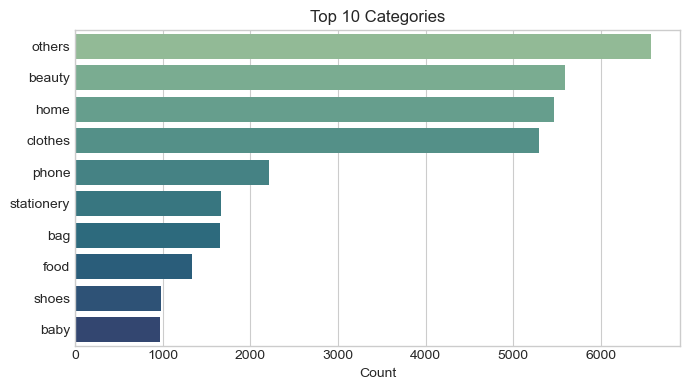

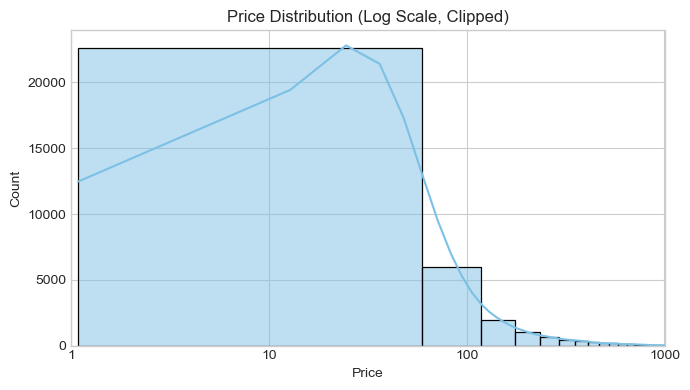

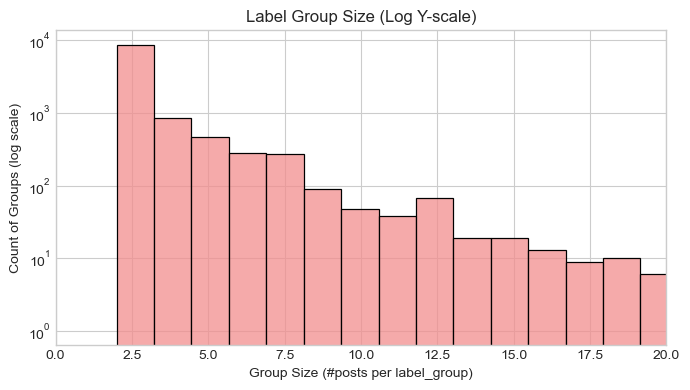

In [21]:
import matplotlib.ticker as mticker

plt.figure(figsize=(7,4))
top_cats = df['category'].value_counts().head(10)
sns.barplot(x=top_cats.values, y=top_cats.index, palette='crest')
plt.title('Top 10 Categories')
plt.xlabel('Count')
plt.ylabel('')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
sns.histplot(df['price'], bins=40, color='#7dc0e5', kde=True)
plt.xscale('log')
plt.xlim(1, 1000)  
plt.title('Price Distribution (Log Scale, Clipped)')
plt.xlabel('Price')
plt.ylabel('Count')
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
group_sizes = df.groupby('label_group')['posting_id'].count()
sns.histplot(group_sizes, bins=40, color='#f28e8e')
plt.xlim(0, 20)   
plt.yscale('log') 
plt.title('Label Group Size (Log Y-scale)')
plt.xlabel('Group Size (#posts per label_group)')
plt.ylabel('Count of Groups (log scale)')
plt.tight_layout()
plt.show()

In [22]:
from pathlib import Path

OUT_DIR = Path('artifacts')
OUT_DIR.mkdir(exist_ok=True)

export_cols = [
    'posting_id', 'image', 'title', 'title_clean',
    'brand', 'category', 'price', 'price_std', 'label_group'
]
export_cols = [c for c in export_cols if c in df.columns]  

out_path = OUT_DIR / 'shopee_dataset_cleaned.csv'
df.to_csv(out_path, index=False, encoding='utf-8-sig')

print("Export completed.")
print("File saved to:", out_path.resolve())
print("Total rows:", len(df), " | columns:", len(export_cols))

Export completed.
File saved to: /Users/liuhaoranlaopo/artifacts/shopee_dataset_cleaned.csv
Total rows: 34250  | columns: 9


# 5. Image Preprocessing

Image folder exists: True
Sample image path: train_images/2acfffc7636789596041b426cbd345af.jpg


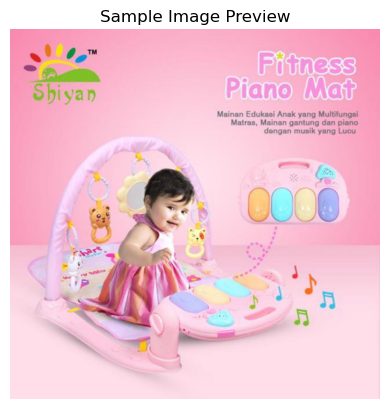

In [3]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

IMG_DIR = Path('train_images')  
print("Image folder exists:", IMG_DIR.exists())

sample_path = next(IMG_DIR.glob('*.jpg'))  
print("Sample image path:", sample_path)

img = Image.open(sample_path)
plt.imshow(img)
plt.axis('off')
plt.title("Sample Image Preview")
plt.show()

In [4]:
from pathlib import Path
from PIL import Image
from tqdm import tqdm

IMG_DIR = Path('train_images')  
PROC_DIR = Path('processed_images'); PROC_DIR.mkdir(exist_ok=True)

def center_crop_to_square(img: Image.Image) -> Image.Image:
    w, h = img.size
    side = min(w, h)
    left = (w - side) // 2
    top  = (h - side) // 2
    return img.crop((left, top, left + side, top + side))

TARGET = 256  

processed = 0
for p in tqdm(list(IMG_DIR.glob('*.jpg')), desc='Preprocessing images'):
    dst = PROC_DIR / p.name
    if dst.exists():   
        processed += 1
        continue
    try:
        with Image.open(p) as im:
            im = im.convert('RGB')
            im = center_crop_to_square(im)
            im = im.resize((TARGET, TARGET), Image.BICUBIC)
            im.save(dst, format='JPEG', quality=85, optimize=True)
            processed += 1
    except Exception as e:
       
        pass

print("Processed images saved to:", PROC_DIR.resolve())
print("Processed count:", processed)

Preprocessing images: 100%|███████████████| 32412/32412 [05:24<00:00, 99.97it/s]

Processed images saved to: /Users/liuhaoranlaopo/Desktop/KM 6312 Group Project/processed_images
Processed count: 32412


In [5]:
import numpy as np
import pandas as pd
from PIL import Image

def image_features(path: Path) -> dict:
    if not path.exists():
        return dict(width=None, height=None, aspect=None,
                    r=None, g=None, b=None, gray=None, entropy=None, ahash=None)
    with Image.open(path) as im:
        im = im.convert('RGB')
        w, h = im.size
        arr = np.array(im)
        r = float(arr[...,0].mean()); g = float(arr[...,1].mean()); b = float(arr[...,2].mean())
        gray = float(arr.mean())
        # Shannon entropy (approx.)
        hist, _ = np.histogram(arr, bins=256, range=(0,255), density=True)
        hist = hist[hist > 0]
        entropy = float(-(hist * np.log2(hist)).sum())
        # average hash (8x8)
        small = im.resize((8,8), Image.BILINEAR).convert('L')
        s = np.array(small, dtype=np.float32)
        bits = (s > s.mean()).astype(np.uint8).flatten()
        ahash = ''.join([f'{int("".join(bits[i:i+4].astype(str)),2):x}' for i in range(0,64,4)])
        return dict(width=w, height=h, aspect=round(w/h,3),
                    r=r, g=g, b=b, gray=gray, entropy=entropy, ahash=ahash)

proc_files = list(PROC_DIR.glob('*.jpg'))
feat_rows = []
for p in tqdm(proc_files, desc='Extracting features'):
    d = image_features(p)
    d['image'] = p.name          
    d['proc_path'] = str(p)
    feat_rows.append(d)

img_feat = pd.DataFrame(feat_rows)
print("Feature shape:", img_feat.shape)
img_feat.head()

Extracting features: 100%|███████████████| 32412/32412 [01:37<00:00, 331.36it/s]


Feature shape: (32412, 11)


,width,height,aspect,r,g,b,gray,entropy,ahash,image,proc_path
0,256,256,1.0,239.825531,189.607513,205.529068,211.654037,6.630399,00387c4e0e8f8fff,2acfffc7636789596041b426cbd345af.jpg,processed_images/2acfffc7636789596041b426cbd34...
1,256,256,1.0,225.623337,177.727188,158.539841,187.296789,5.629360,ffff9f8181000000,a68eb1b5a0c1c326d7b6ef42cfddaf69.jpg,processed_images/a68eb1b5a0c1c326d7b6ef42cfdda...
2,256,256,1.0,171.704453,142.592499,143.819275,152.705409,7.899171,8090f3e880c3edff,effc540299fe3a4b132802f0a9547a4e.jpg,processed_images/effc540299fe3a4b132802f0a9547...
3,256,256,1.0,205.516388,206.596115,198.601730,203.571411,4.108286,ffc3c3c3c3c3c7ff,53bd87d83a50740667ecd736bb067388.jpg,processed_images/53bd87d83a50740667ecd736bb067...
4,256,256,1.0,201.356537,137.044479,136.605331,158.335449,6.543106,fffffff0f8f8f0e0,5799f0087fb40852b8e52738dfe74da9.jpg,processed_images/5799f0087fb40852b8e52738dfe74...
